In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
from collections import namedtuple
from collections import defaultdict

In [27]:
class Superpixel:
    def __init__(self):
        self.area = 0
        self.x_min = None
        self.x_max = None
        self.y_min = None
        self.y_max = None
        self.x_centroid = 0
        self.y_centroid = 0
        self.Lab_mean = 0
        
        
    def update(self, x, y, Lab):        
        self.area += 1
        if self.area == 1:
            self.x_min, self.x_max = x, x
            self.y_min, self.y_max = y, y
        else:
            self.x_min = min(self.x_min, x)
            self.y_min = min(self.y_min, y)
            self.x_max = max(self.x_max, x)
            self.y_max = max(self.y_max, y)
        
        self.x_centroid += x
        self.y_centroid += y
        self.Lab_mean += Lab
        
    @property
    def xc(self):
        if self.area != 0:            
            return self.x_centroid/self.area
        else:
            return None
    
    @property
    def yc(self):
        if self.area != 0:
            return self.y_centroid/self.area
        else:
            return None
        
    @property
    def Lab(self):
        if self.area != 0:            
            return self.Lab_mean/self.area
        else:
            return None
        
        
    def __str__(self):
        return ' - '.join(["({xmin}, {ymin}, {xmax}, {ymax})",
                           "({xc}, {yc})",
                           "{area}",
                           "{Lab}"])\
                    .format(xmin=self.x_min,
                            ymin=self.y_min,
                            xmax=self.x_max,
                            ymax=self.y_max,
                            xc=self.xc,
                            yc=self.yc,
                            area=self.area,
                            Lab=self.Lab)
        
    def __repr__(self):
        return self.__str__()

In [31]:
def opencvLAB(Lab):
    Lab32 = Lab.astype(np.float32)
    Lab32[..., 0] *= 100 / 255
    Lab32[..., 1] -= 128
    Lab32[..., 2] -= 128
    return Lab32

def deltaE(Lab1, Lab2):
    L1, a1, b1 = opencvLAB(Lab1)
    L2, a2, b2 = opencvLAB(Lab2)
    dL = L1 - L2
    da = a1 - a2
    db = b1 - b2
    return np.sqrt(dL * dL + da * da + db * db)

In [32]:
test_bgr = np.array([[[90, 78, 26]]], np.uint8)
test_lab_cv = cv2.cvtColor(test_bgr, cv2.COLOR_BGR2Lab)
test_lab = opencvLAB(test_lab_cv)

In [33]:
im_block = cv2.imread("../data/sealion/TrainBlock/32_3.jpg")

In [34]:
im_lab = cv2.cvtColor(im_block, cv2.COLOR_BGR2Lab)
im_lab = opencvLAB(im_lab)

In [35]:
a = cv2.ximgproc.createSuperpixelSLIC(im_block, cv2.ximgproc.SLICO, 10, 10.0)

In [36]:
a.iterate(20)

In [37]:
a.getNumberOfSuperpixels()

18486

True

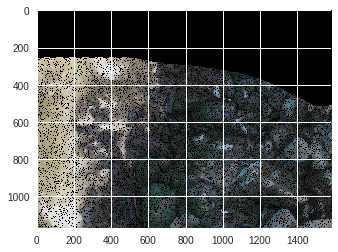

In [75]:
b = ((a.getLabelContourMask() == 0) * 255).astype(np.uint8)
im_with_sp_contours = cv2.bitwise_and(im_block,im_block,mask = b)
plt.imshow(im_with_sp_contours)
cv2.imwrite("../data/superpixel.png", im_with_sp_contours)

In [41]:
labels = a.getLabels()

In [42]:
def analyze_superpixels(labels, im_Lab):
    labels_set = np.unique(labels)
    n_labels = labels_set.shape[0]
    
    h, w = labels.shape
    
    superpixels = defaultdict(Superpixel)
    neighbors = defaultdict(set)
    weights = defaultdict(int)
    dxs = [1, 0, -1, 0]
    dys = [0, 1, 0, -1]
    for y in range(h):
        for x in range(w):
            label = labels[y, x]
            superpixels[label].update(x, y, im_Lab[y, x])
            for dx, dy in zip(dxs, dys):
                if 0 <= x + dx < w and 0 <= y + dy < h:
                    n = labels[y + dy, x + dx]
                    if n != label:
                        neighbors[label].add(n)
                        weights[label] += 1
    return superpixels, neighbors, weights

In [43]:
superpixels, neighbors, weights = analyze_superpixels(labels, im_lab)

In [44]:
superpixels[0]

(872, 758, 883, 770) - (877.9818181818182, 764.4363636363636) - 110 - [ 26.60605621  -5.5181818   12.9636364 ]

In [97]:
def segmentation(dot, labels, superpixels, neighbors, weights, min_area=1200, max_area=2200, max_color_distance=6.0, max_distance=36):
    mask = np.zeros(labels.shape, np.uint8)
    x, y, = dot
    sp_id = labels[y,x]
    print("sp_id: ", sp_id)
    sps_sealion = set([sp_id])
    total_area = superpixels[sp_id].area
    mask[labels==sp_id] = 255
    cv2.imwrite("../data/sp_start.png", mask)
    step = 0
    while 1:
        # find the closest neighbor
        seen_neighbors = sps_sealion.copy()
        closest_sp_id = -1
        closest_distance = 1e9
        
        for sp in sps_sealion:
            for neighbor in neighbors[sp]:
                if neighbor not in sps_sealion:
                    dx = (x - superpixels[neighbor].xc)
                    dy = (y - superpixels[neighbor].yc)
                    distance_to_center = np.sqrt(dx * dx + dy * dy)
                    if distance_to_center < max_distance:
                        distance_color = deltaE(superpixels[sp].Lab, superpixels[neighbor].Lab)
                        if distance_color < closest_distance:
                            closest_distance = distance_color
                            closest_sp_id = neighbor
                        
        print("closest: ", step, closest_sp_id, closest_distance)
        if total_area > min_area and closest_distance > max_color_distance:
            # too far, and big enough, we stop
            print("too far")
            return sps_sealion
        
        if total_area + superpixels[closest_sp_id].area > max_area:
            # too big with this sp, we stop
            print("too big")
            return sps_sealion
        
        sps_sealion.add(closest_sp_id)
        total_area += superpixels[closest_sp_id].area
        mask[labels==closest_sp_id] = 255
        print("area: ", step, total_area)
        cv2.imwrite("../data/sp_{step}.png".format(step=step), mask)
        step += 1
    return sps_sealion

In [98]:
d = segmentation((959, 432), labels, superpixels, neighbors, weights)

sp_id:  6889
closest:  0 6890 1.88432
area:  0 209
closest:  1 6731 2.21199
area:  1 311
closest:  2 6572 1.32233
area:  2 394
closest:  3 7047 2.44654
area:  3 498
closest:  4 6732 2.87456
area:  4 612
closest:  5 6573 1.57814
area:  5 707
closest:  6 6574 2.36835
area:  6 804
closest:  7 7048 3.7132
area:  7 914
closest:  8 7049 1.67404
area:  8 1026
closest:  9 7206 2.17631
area:  9 1146
closest:  10 7207 2.13723
area:  10 1257
closest:  11 6416 4.18101
area:  11 1352
closest:  12 6733 4.59864
area:  12 1451
closest:  13 6888 4.76683
area:  13 1532
closest:  14 7205 6.79409
too far


In [99]:
d = segmentation((875, 685), labels, superpixels, neighbors, weights, min_area=800)

sp_id:  10831
closest:  0 10988 2.02213
area:  0 222
closest:  1 10832 3.23118
area:  1 357
closest:  2 10674 1.03495
area:  2 488
closest:  3 10987 3.69861
area:  3 614
closest:  4 10986 2.76771
area:  4 725
closest:  5 10673 4.15976
area:  5 822
closest:  6 10830 4.88769
area:  6 924
closest:  7 10833 6.5922
too far


In [100]:
d = segmentation((1248, 743), labels, superpixels, neighbors, weights, min_area=500)

sp_id:  11816
closest:  0 11815 1.45099
area:  0 237
closest:  1 11973 1.57211
area:  1 352
closest:  2 11974 6.05843
area:  2 476
closest:  3 11817 4.94129
area:  3 575
closest:  4 11975 6.57489
too far


In [101]:
d = segmentation((944, 1025), labels, superpixels, neighbors, weights, min_area=500)

sp_id:  16210
closest:  0 16051 4.01212
area:  0 224
closest:  1 15893 2.2567
area:  1 323
closest:  2 16209 2.88089
area:  2 428
closest:  3 15734 3.2473
area:  3 533
closest:  4 16366 3.89502
area:  4 689
closest:  5 16208 2.09033
area:  5 800
closest:  6 16049 3.06546
area:  6 893
closest:  7 15891 2.79325
area:  7 987
closest:  8 15892 1.52443
area:  8 1050
closest:  9 16050 1.5824
area:  9 1142
closest:  10 16048 2.85487
area:  10 1253
closest:  11 16207 2.05493
area:  11 1348
closest:  12 16367 4.37637
area:  12 1490
closest:  13 16526 1.93524
area:  13 1637
closest:  14 16525 4.45301
area:  14 1759
closest:  15 16524 2.83528
area:  15 1860
closest:  16 16682 1.82883
area:  16 1932
closest:  17 16683 2.18283
area:  17 2011
closest:  18 16365 2.32651
area:  18 2075
closest:  19 16523 2.30501
area:  19 2156
closest:  20 15735 4.52144
too big
